In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split

import hervpd as hp
import plotReport as pr

## 1. Data description

In [3]:
df = pd.read_excel('/home/ju/GDrive/Projects/HeRV/Data/PreProcessed/df_90_300.xlsx')
df.describe()

,hf,hfnu,lf,lf_hf,lfnu,mhr,mrri,nn50,order,pnn50,rmssd,sdnn,sess,total_power,user,vlf
count,2.694000e+03,2694.000000,2.694000e+03,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2.694000e+03,2694.000000,2.694000e+03
mean,2.387300e+04,45.815472,4.127698e+05,2.465940,54.184528,78.661621,819.019148,89.473645,18.990720,25.773847,112.382566,114.926574,162.705642,1.475527e+06,1.624722,1.038884e+06
std,1.821238e+05,23.079335,8.977828e+06,4.822733,23.079335,18.109035,173.770072,71.387172,24.864286,22.689257,169.919067,122.765916,117.628292,4.585638e+07,2.009594,3.707927e+07
min,5.751146e-01,1.419545,2.567078e+00,0.027289,2.656368,47.596407,334.157205,0.000000,0.000000,0.000000,3.369205,13.625541,0.000000,3.390064e+01,0.000000,2.559104e+01
25%,3.727382e+02,26.437869,5.863960e+02,0.563744,36.050930,66.002474,703.884813,30.000000,2.000000,7.290387,33.034351,53.887830,63.000000,1.761790e+03,0.000000,5.059374e+02
50%,9.172297e+02,43.726407,1.280138e+03,1.286951,56.273593,77.199486,793.543971,72.000000,7.000000,18.870437,53.744197,77.456919,135.000000,3.576149e+03,1.000000,1.088380e+03
75%,4.668043e+03,63.949070,3.023524e+03,2.782454,73.562131,87.023533,933.362043,136.000000,29.000000,39.789854,131.090808,138.225573,295.000000,1.190274e+04,2.000000,2.524048e+03
max,6.139868e+06,97.343632,4.263838e+08,69.445109,98.580455,180.176325,1269.037344,354.000000,113.000000,91.726619,2239.263240,1776.464653,350.000000,2.338062e+09,6.000000,1.905538e+09


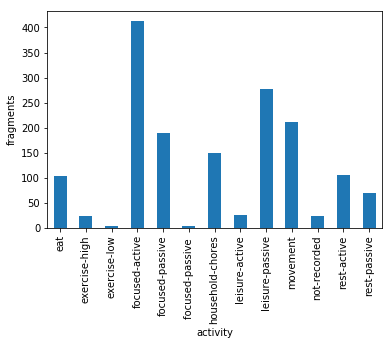

In [4]:
hp.plot_count(df, 'activity', exclude=['sleep'])

## 2A. Data preparation - Inserting labels for aggregating categories:

* 1: move vs still = exercise (high and low intensity), movement, household chores X *others*
* 2: sleep vs awake =  sleep X *others*
* 3: move vs sleep vs stand = Move (from 1) X Sleep (from 2) X *others*


In [5]:
movelist = ['exercise-high', 'exercise-low', 'movement', 'household-chores']
df = hp.add_partition(df, movelist, pname='moving', labelIn=1, labelOut=0)
    
sleeplist = ['sleep']
df = hp.add_partition(df, sleeplist, pname='sleeping', labelIn=1, labelOut=0)

activelist = ['rest-active', 'focused-active', 'leisure-active', 'eat']
df = hp.add_partition(df, activelist, pname='active', labelIn=1, labelOut=0)

passivelist = ['rest-passive', 'leisure-passive', 'focused-passive', 'focused-passive ']
df = hp.add_partition(df, passivelist, pname='passive', labelIn=1, labelOut=0)

df['focused'] = np.where(df['activity'].isin(['focused-passive', 'focused-passive ','focused-active']), 1, 0)
df['relaxed'] = np.where(df['activity'].isin(['rest-active', 'rest-passive', 'leisure-passive', 'leisure-active']), 1, 0)

df['lyingdown'] = np.where(df['posture'].isin(['lie', 'lying down']), 1, 0)
df['sitting'] = np.where(df['posture'].isin(['sit','sitting']), 1, 0)
df['standing'] = np.where(df['posture'].isin(['stand','standing', 'standing ']), 1, 0)


## 2B. Data preparation - scaling and splitting test and train datasets

In [6]:
features_all = ['hf', 'hfnu', 'lf', 'lf_hf', 'lfnu', 'mhr', 'mrri', 'nn50', 'pnn50', 'rmssd', 'sdnn', 'total_power', 'vlf']
features_red = ['hf', 'lf', 'vlf', 'lf_hf', 'mhr', 'mrri', 'pnn50', 'rmssd', 'sdnn']

one_hot_labels = ['moving', 'sleeping', 'sitting', 'standing', 'lyingdown', 'active', 'passive', 'focused', 'relaxed']
all_labels = ['activity', 'posture', 'moving', 'sleeping', 'sitting', 'standing', 'lyingdown', 'active', 'passive', 'focused', 'relaxed']

for l in all_labels:
    print(hp.count_by(df, l))

activity
eat                  103
exercise-high         24
exercise-low           4
focused-active       413
focused-passive      189
focused-passive        4
household-chores     150
leisure-active        27
leisure-passive      278
movement             212
not-recorded          25
rest-active          106
rest-passive          69
sleep               1090
Name: user, dtype: int64
posture
lie           682
lying down    448
posture        26
sit           823
sitting       325
stand         198
standing      184
standing        8
Name: user, dtype: int64
moving
0    2304
1     390
Name: user, dtype: int64
sleeping
0    1604
1    1090
Name: user, dtype: int64
sitting
0    1546
1    1148
Name: user, dtype: int64
standing
0    2304
1     390
Name: user, dtype: int64
lyingdown
0    1564
1    1130
Name: user, dtype: int64
active
0    2045
1     649
Name: user, dtype: int64
passive
0    2154
1     540
Name: user, dtype: int64
focused
0    2088
1     606
Name: user, dtype: int64
relaxed
0    

In [7]:
train, test = hp.preprocess(df, features_all)
ttu = [hp.preprocess(hp.user_data(df, user), features_all) for user in range(7)]
print ([(len(ttu[i][0]), len(ttu[i][1])) for i in range(7)])

2155 539
1028 258
242 61
352 89
43 11
161 41
180 46
145 37
[(1028, 258), (242, 61), (352, 89), (43, 11), (161, 41), (180, 46), (145, 37)]


## 3. SVM classification - Moving vs still (including sleep in still activities)

In [8]:
label='activity'
#c1, c2, gamma = hp.model_selection_svm(df, feature_list, labelName=label)
c1, c2, gamma = (10, 10, 0.1)

### 3A. For all users combined

In [9]:
c1 = 10
c2 = 10
gamma = 0.1
for label in all_labels:
    clf_svm = hp.clf_svm_rbf(train, features_all, labelName=label, C=c2, gamma=gamma)
    print(label, ': ', hp.report_test(clf_svm, test, features_all, labels=[label], print_report=False, plot_report=False))

/home/ju/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 13, does not match size of target_names, 2
  .format(len(labels), len(target_names))
/home/ju/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


activity :  0.384044526902


/home/ju/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 7, does not match size of target_names, 2
  .format(len(labels), len(target_names))


posture :  0.30426716141
moving :  0.87012987013
sleeping :  0.615955473098
sitting :  0.541743970315
standing :  0.866419294991
lyingdown :  0.602968460111
active :  0.727272727273
passive :  0.786641929499
focused :  0.764378478664
relaxed :  0.797773654917


### 3B. For each user (SVM moving x still)

In [17]:
label='moving'
for user in [0,1,2,3,5]:
    train_u, test_u = ttu[user]
    print ('---------------- User: ', user, ' ----------------------')
    clf_svm = hp.clf_svm_rbf(train_u, features_all, labelName=label, C=c2, gamma=gamma)
    print(hp.report_test(clf_svm, test_u, features_all, labels=[label], print_report=True, plot_report=False), '\n')

---------------- User:  0  ----------------------
             precision    recall  f1-score   support

 not moving       0.82      1.00      0.90       211
     moving       0.00      0.00      0.00        47

avg / total       0.67      0.82      0.74       258

0.817829457364 

---------------- User:  1  ----------------------
             precision    recall  f1-score   support

 not moving       0.90      1.00      0.95        55
     moving       0.00      0.00      0.00         6

avg / total       0.81      0.90      0.86        61

0.901639344262 

---------------- User:  2  ----------------------
             precision    recall  f1-score   support

 not moving       0.83      1.00      0.91        74
     moving       0.00      0.00      0.00        15

avg / total       0.69      0.83      0.75        89

0.831460674157 

---------------- User:  3  ----------------------
             precision    recall  f1-score   support

 not moving       0.45      1.00      0.62        

/home/ju/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 3C. For each user (SVM awake  x sleep)

In [20]:
label='sleeping'
for user in df.loc[df[label]==1].user.unique(): #users that have sleep data
    train_u, test_u = ttu[user]
    print ('---------------- User: ', user, ' ----------------------')
    clf_svm = hp.clf_svm_rbf(train_u, features_all, labelName=label, C=c2, gamma=gamma)
    print(hp.report_test(clf_svm, test_u, features_all, labels=[label], print_report=True, plot_report=False), '\n')

---------------- User:  0  ----------------------
              precision    recall  f1-score   support

not sleeping       0.53      1.00      0.69       137
    sleeping       0.00      0.00      0.00       121

 avg / total       0.28      0.53      0.37       258

0.531007751938 

---------------- User:  1  ----------------------
              precision    recall  f1-score   support

not sleeping       0.92      1.00      0.96        56
    sleeping       0.00      0.00      0.00         5

 avg / total       0.84      0.92      0.88        61

0.918032786885 

---------------- User:  2  ----------------------
              precision    recall  f1-score   support

not sleeping       0.81      1.00      0.89        72
    sleeping       0.00      0.00      0.00        17

 avg / total       0.65      0.81      0.72        89

0.808988764045 

---------------- User:  4  ----------------------
              precision    recall  f1-score   support

not sleeping       0.00      0.00    

/home/ju/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 5. Random Forest classifier 

### 4A. For each label separately

In [67]:
for label in all_labels:
    clf = hp.clf_rf(train, features_all, labels=[label])
    print(label, ': ', clf.score(X=test[features_all], y=test[label]))
    

activity :  0.556586270872
posture :  0.65306122449
moving :  0.897959183673
sleeping :  0.881261595547
still :  0.803339517625
sitting :  0.779220779221
standing :  0.894248608534
lyingdown :  0.888682745826
active :  0.807050092764
passive :  0.807050092764
focused :  0.78107606679
relaxed :  0.807050092764


moving :  0.896103896104
sleeping :  0.875695732839
sitting :  0.779220779221
standing :  0.894248608534
lyingdown :  0.871985157699
active :  0.797773654917
passive :  0.805194805195
focused :  0.773654916512
relaxed :  0.812615955473


<Container object of 9 artists>

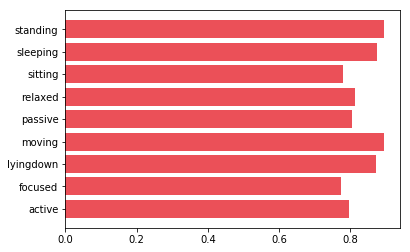

In [75]:
scores = []
for label in one_hot_labels:
    clf = hp.clf_rf(train, features_red, labels=[label])
    score = clf.score(X=test[features_red], y=test[label])
    print(label, ': ', score)
    scores.append(score)
    #print(hp.report_test(clf, test, features_red, labels=[label], print_report=False, plot_report=False), '\n')
    
plt.barh(one_hot_labels, scores, align='center', alpha=1, color='#eb5058')

In [78]:
ul = [[] for i in range(len(one_hot_labels))]
for user in [0,1,2,4,5,6]:
    print('\n-------------- USER: ', user, '--------------')
    train_u, test_u = ttu[user]    
    for i,label in enumerate(one_hot_labels):
        clf = hp.clf_rf(train_u, features_red, labels=[label])        
        score = clf.score(X=test_u[features_red], y=test_u[label])
        print(label, ': ', score)
        ul[i].append(score)
        


-------------- USER:  0 --------------
moving :  0.852713178295
sleeping :  0.875968992248
sitting :  0.755813953488
standing :  0.841085271318
lyingdown :  0.868217054264
active :  0.856589147287
passive :  0.860465116279
focused :  0.837209302326
relaxed :  0.903100775194

-------------- USER:  1 --------------
moving :  1.0
sleeping :  0.967213114754
sitting :  0.950819672131
standing :  1.0
lyingdown :  0.934426229508
active :  0.754098360656
passive :  0.737704918033
focused :  0.83606557377
relaxed :  0.819672131148

-------------- USER:  2 --------------
moving :  0.865168539326
sleeping :  0.932584269663
sitting :  0.797752808989
standing :  0.865168539326
lyingdown :  0.898876404494
active :  0.719101123596
passive :  0.696629213483
focused :  0.685393258427
relaxed :  0.808988764045

-------------- USER:  4 --------------
moving :  1.0
sleeping :  0.878048780488
sitting :  0.878048780488
standing :  1.0
lyingdown :  0.853658536585
active :  1.0
passive :  0.878048780488
focu

[0.94935709786427225, 0.91067307064964886, 0.85731538739654756, 0.94291460886364387, 0.89423358193275282, 0.8504015130119259, 0.8341350709104326, 0.87509333773582199, 0.86231739054697876]


<Container object of 9 artists>

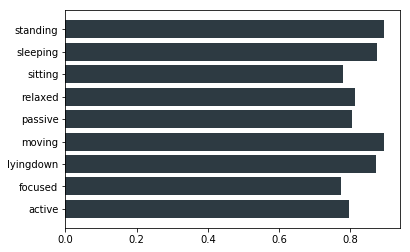

In [80]:
print([np.mean(l) for l in ul])
plt.barh(one_hot_labels, scores, align='center', alpha=1, color='#2d3a42')

### 4B. For multi-1-hot encoded labels

             precision    recall  f1-score   support

     moving       0.72      0.50      0.59        72
   sleeping       0.89      0.79      0.83       227
      still       0.75      0.83      0.79       240
    sitting       0.73      0.80      0.76       226
   standing       0.70      0.47      0.56        75
  lyingdown       0.90      0.82      0.86       233

avg / total       0.80      0.77      0.78      1073

[0.72, 0.5, 0.59]
[0.89, 0.79, 0.83]
[0.75, 0.83, 0.79]
[0.73, 0.8, 0.76]
[0.7, 0.47, 0.56]
[0.9, 0.82, 0.86]


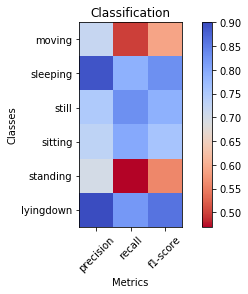

0.723562152134 



In [30]:
clf = hp.clf_rf(train, features_all, labels=one_hot_labels)
print(hp.report_test(clf, test, features_all, labels=one_hot_labels, print_report=True, plot_report=True), '\n')

In [32]:
for user in [0,1,2,5,6]: 
    print('-------------- USER: ', user, '--------------')
    dfu = hp.user_data(df, user)
    clf = hp.clf_rf(train, features_red, labels=one_hot_labels)
    print(clf.score(X=test[features_red], y=test[one_hot_labels]))
    
    

-------------- USER:  0 --------------
0.734693877551
-------------- USER:  1 --------------
0.719851576994
-------------- USER:  2 --------------
0.732838589981
-------------- USER:  5 --------------
0.723562152134
-------------- USER:  6 --------------
0.721706864564


In [57]:
df_nm = hp.filter_out(df, 'moving', [1])
df_nm.sample(20)
train, test = hp.preprocess(df_nm, features_red)
for label in all_labels:
    clf = hp.clf_rf(train, features_red, labels=[label])
    print(label, ': ', clf.score(X=test[features_red], y=test[label]))

1843 461
activity :  0.63557483731
posture :  0.748373101952
moving :  1.0
sleeping :  0.848156182213
still :  0.845986984816
sitting :  0.843817787419
standing :  0.991323210412
lyingdown :  0.8568329718


In [ ]:
hp.run_rf(df_wake, feature_list, labels, print_report=True, plot_report=True)

In [ ]:
for user in [0,1,2,5,6]: 
    print('-------------- USER: ', user, '--------------')
    dfu = hp.user_data(df_wake, user)
    uscore = hp.run_rf(dfu, feature_list, labels, plot_report=True)
    print(uscore, '\n\n')